# Drivers of Reddit NFL sentiment
This notebook investigates what drives the sentiment of NFL players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nba-sentiment.ipynb`.

### Short term to-do:
* Clean up comment matching
  * Why does JJ Watt have low comment count?
* Add salary data and Trump vote share
* Try to find some subset of data where performance is correlated with sentiment

### Long term to-do:

Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

In [1]:
import json
import string
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [4]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Baltimore Ravens Buffalo Bills Cincinnati Bengals Cleveland Browns Denver Broncos Houston Texans Indianapolis Colts ' \
                        'Jacksonville Jaguars Kansas City Chiefs Los Angeles Chargers Miami Dolphins New England Patriots New York Jets ' \
                        'Oakland Raiders Pittsburgh Steelers Tennessee Titans NFL Bowl ' \
                       'Arizona Cardinals Atlanta Falcons Carolina Panthers Chicago Bears Dallas Cowboys Detroit Lions Green Bay Packers ' \
                        'Los Angeles Rams Minnesota Vikings New Orleans Saints New York Giants Philadelphia Eagles San Francisco 49ers ' \
                        'Seattle Seahawks Tampa Bay Buccaneers Washington Redskins ' \
                        'Goodell Lebron jags cards hawks bucs skins'.lower().split())

In [6]:
#coaches2018_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_current_National_Football_League_head_coaches')[0].iloc[2:, 1].str.strip(string.punctuation).str.lower().str.split(' ').str[-1]
#coaches2018_df.to_csv('d:/data/sentiment_sports/nfl_coaches_2018.csv', index=False)
coaches = set(pd.read_csv('d:/data/sentiment_sports/nfl_coaches_2018.csv', header = None).iloc[:,0])

In [7]:
non_players_set = non_players_set.union(set(coaches))

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [145]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win',
              'championship', 'championships']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation', 'attack',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'rob', 'freeman', 'hardy', 'threat', 'loss', 'losses', 'playing']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'soft',
             'garbage', 'delusional', 'slow', 'douchey', 'cheap', 'creepy']
great_words = ['goat', 'nasty', 'prime', 'mvp', 'master', 'all-star']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

In [8]:
city_mapping = {'ARI':'PHO', 'CAR':'CHO', 'GNB':'GB', 'JAX':'JAC', 'KAN':'KC', 'LACH':'LAC', 'LARM':'LAR',
                'NE':'BOS', 'NWE':'BOS', 'NOR':'NOP', 'NO':'NOP', 'SD':'SDG','SFO':'SF', 'TAM':'TB'}

## 1. Load player demographic and performance data
### Demographics
#### Ethnicity
To get a list of black players, I queried Wikipedia's Categories for African American football players and Samon players. This list contained a large fraction of players, but did not label all players, nor identify white NFL players. I then supplemented this list by Googling the ethnicity of the remaining players

In [9]:
nonwiki_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players_race_unknown.csv')

In [11]:
race_nfl_df = pd.concat([pd.read_csv('d:/data/sentiment_sports/covariates/nfl_race_players.tsv', sep='\t'),
                        nonwiki_df])

#### Download demographics of recent players with weight, height, etc.
`pro-football-reference.com` has non-racial demographic data for players going back to the fifties. Here I download those players' data, and filter to recent players.

In [12]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players2010-2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()
demo_df['position'] = demo_df['position'].str.strip('()').str.lower().str.split('-').str[0]
def map_name(name):
    if '.' in name:
        return name.replace('.', ' ').replace('  ', ' ') # <- janky
    return name.split(' ')[0][0] + ' ' + name.split(' ')[1]
demo_df['player_join'] = demo_df['Player'].apply(map_name)

In [13]:
# have to manually fix some player name mappings
player_map = {'ej manuel':'ej manuel',
                         'marlon brown': 'ma brown',  'mike brown': 'mi brown', 'john brown': 'jo brown',
                         'deangelo williams': 'de williams', 'david johnson':'da johnson',
                         'trent taylor':'tr taylor', 'jj nelson': 'j j nelson',
                         'jaron brown':'ja brown', "nick o\\'leary": "n o'leary"
                         }
demo_df['player_join'] = demo_df.apply(lambda row: player_map[row['Player']] if row['Player'] in player_map else row['player_join'], axis=1)
position_map = {'fb':'rb'}
demo_df['position'] = demo_df['position'].replace(position_map)
demo_df['Tm'] = demo_df['Tm'].replace(city_mapping)

#### Player performance
For player performance, I download data from `footballoutsiders.com`

In [14]:
#performance_df.to_csv('d:/data/sentiment_sports/nfl_stats_2012-2017.tsv', sep='\t', index = False)
performance_df = (pd.read_csv('d:/data/sentiment_sports/nfl_stats_2012-2017.tsv', sep='\t')
                    .rename(columns={'Team':'Tm'}))
performance_df['player_join'] = performance_df['Player'].str.replace('.', ' ').str.lower()

In [18]:
performance_df['Tm'] = performance_df['Tm'].replace(city_mapping)

#### Team info
Here I download team performance from `pro-football-outsiders.com`

In [17]:
#team_df.to_csv('d:/data/sentiment_sports/covariates/nfl_teams_2012-2018.tsv', sep='\t', index=False)
team_df= pd.read_csv('d:/data/sentiment_sports/covariates/nfl_teams_2012-2018.tsv', sep='\t')

#### Salary

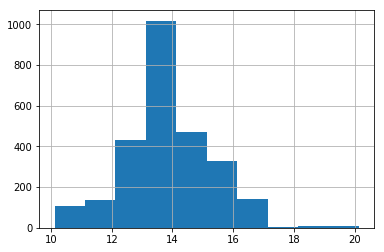

In [57]:
np.log(salary_df['salary']).hist();

In [16]:
salary_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_salary.tsv', sep='\t')

#### City demographics
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for NFL cities.

In [153]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

In [162]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combine them into a single dataframe that has performance, demographics, and city information.

In [163]:
covariates_df = (performance_df.merge(demo_df, on = ['player_join', 'position', 'Tm', 'year'], how='left', suffixes=('_FO', ''))
                             .merge(race_nfl_df, on='Player', how='left')
                             .merge(salary_df, on=['Player', 'year'], how='left')
#                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm', how='left')
                      .merge(vote_df, on='Tm', how='left')
                      .dropna(subset= ['start_year'])
                )
covariates_df['experience'] = covariates_df['year'] - covariates_df['start_year']
covariates_df.head(2)

,Player_FO,Tm,position,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,player_join,Player,level_1,start_year,end_year,url,height,weight,birth_date,race,salary,standard_salary,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,T.Brady,BOS,qb,2035,35.1,34,2.574492,1.846341,1.437475,2012,t brady,tom brady,12.0,2000.0,2018.0,/players/B/BradTo00.htm,76.0,225.0,"August 3, 1977",W,NaN,NaN,4728844.0,77.3,8.0,0.3815,12.0
1,P.Manning,DEN,qb,1805,32.8,37,2.222644,1.738123,1.722051,2012,p manning,peyton manning,14.0,1998.0,2015.0,/players/M/MannPe00.htm,77.0,230.0,"March 24, 1976",W,NaN,NaN,2752056.0,81.9,5.6,0.5638,14.0


#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [21]:
UNIQUE_NAMES = {x.replace('\\', '') for x in set(demo_df.Player.unique())}

In [22]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'rg3', 'obj', 'saquads', 'cantguardmike', 'tractorcito', 'bmarsh',
                                                            'berman', 'coughlin', 'dungy', 'mcdaniels', 'spanos', 'gronk', 'bledsoe', 'garopolo'})
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Ah', 'Black', 'Ball', 'Battle', 'Bell', 'Best', 'Blue', 'Board', 'Brown', 'Buddy', 'Burden',
                  'Case', 'Chance', 'Choice', 'City', 'Cook', 'Dare', 'Day', 'Early',
                  'Fish', 'Free', 'Grant', 'Good', 'Hand', 'Heard', 'Hill', 'Hope', 'Hurt', 'House', 'Holiday', 'Key',
                  'Little', 'Guy', 'Long', 'Love', 'Light', 'Line', 'Luck', 'Major', 'Means', 'New', 
                  'Pace', 'Person', 'Petty','Pool', 'Price','Rob', 'Rose', 'Red', 'Rock', 'Rush',
                  'Savage', 'Season', 'Short', 'Shorts', 'Strong', 'Small', 'Smart', 'Star', 'Stone', 'Story', 
                  'Temple', 'Tuck', 'Wall', 'Wear', 'Weeks', 'White', 'Will', 'Way', 'West', 'Wise', 'Young', }
NAMED_ENTITIES = NAMED_ENTITIES - {'a', 'g', 'ah', 'you', 'has', 'good', 'still'} - {name.lower() for name in UPPER_ENTITIES}
# remove periods for some names
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)

In [60]:
import importlib
importlib.reload(ss)
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES)

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [61]:
%%time
_, sep_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201709-comments_submissions.tsv')
#_, oct_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201710-comments_submissions.tsv')
#_, nov_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201711-comments_submissions.tsv')
#_, dec_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201712-comments_submissions.tsv')
#_, jan_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201801-comments_submissions.tsv')
#_, feb_df = create_month_df('d:/data/sentiment_sports/nfl_reddit_comments/201802-comments_submissions.tsv')

Loading one month of player comments
Loaded 303436 comments
Filtering to comments with text_length > 20 and text_length < 500
After filter, have 244008 comments
Chunking comments into sentences
Chunking into sentences
Chunked into 453435 sentences
Extracting named entities
Cleaning entities
Outputting 84657 sentences which have 1-2 named entities
Calculating sentiment
Returning 84657 sentences with sentiment and extracted entities
Wall time: 53.1 s


In [25]:
#600k pre non_player filter
nfl2017_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2017_df.shape

(553054, 15)

In [26]:
%%time
# 27 minutes with 8 cores
nfl2017_df = ss.fuzzy_match_players(nfl2017_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 23min


In [ ]:
nfl2017_df.to_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016-2017 season

In [ ]:
%%time
year =2016
_, sep_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}09-comments_submissions.tsv')
_, oct_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}10-comments_submissions.tsv')
_, nov_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}11-comments_submissions.tsv')
_, dec_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}12-comments_submissions.tsv')
_, jan_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}01-comments_submissions.tsv')
_, feb_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}02-comments_submissions.tsv')

In [26]:
nfl2016_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2016_df.shape

(525898, 15)

In [27]:
%%time
# 27 minutes with 8 cores
nfl2016_df = ss.fuzzy_match_players(nfl2016_df, UNIQUE_NAMES, num_workers = 6)

Fuzzy matching player names
Wall time: 1h 1min 4s


In [28]:
nfl2016_df.to_csv('d:/data/sentiment_sports/nfl2016_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015-2016 season

In [ ]:
%%time
year =2015
_, sep_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}09-comments_submissions.tsv')
_, oct_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}10-comments_submissions.tsv')
_, nov_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}11-comments_submissions.tsv')
_, dec_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year}12-comments_submissions.tsv')
_, jan_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}01-comments_submissions.tsv')
_, feb_df = create_month_df(f'd:/data/sentiment_sports/nfl_reddit_comments/{year+1}02-comments_submissions.tsv')

In [30]:
nfl2015_df = pd.concat([sep_df, oct_df, nov_df, dec_df, jan_df, feb_df])
nfl2015_df.shape

(532998, 15)

In [31]:
%%time
# 27 minutes with 8 cores
nfl2015_df = ss.fuzzy_match_players(nfl2015_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 49min 55s


In [32]:
nfl2015_df.to_csv('d:/data/sentiment_sports/nfl2015_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### Save / load

In [33]:
nfl2015_df = pd.read_csv('d:/data/sentiment_sports/nfl2015_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2015_df['named_entities'] = nfl2015_df['named_entities'].apply(literal_eval)
nfl2016_df = pd.read_csv('d:/data/sentiment_sports/nfl2016_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2016_df['named_entities'] = nfl2016_df['named_entities'].apply(literal_eval)
nfl2017_df = pd.read_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2017_df['named_entities'] = nfl2017_df['named_entities'].apply(literal_eval)

In [90]:
nfl2015_df['year'] = 2015
nfl2016_df['year'] = 2016
nfl2017_df['year'] = 2017

#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [132]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'brady moss']}
name_map.update({'barr':'anthony barr', 'bmarsh':'brandon marshall', 'brady': 'tom brady', 'carr':'derek carr', 
                 'carson': 'carson palmer', 'clowney': 'jadeveon clowney', 'cousins': 'kirk cousins', 'crabtree':'michael crabtree', 
                'dak':'dak prescott', 'dalton':'andy dalton', 'dez': 'dez bryant', 'eli': 'eli manning', 'ertz':'zach ertz', 'freeman':'devonta freeman',
                 'goff':'jared goff', 'gore':'frank gore', 'gronk':'rob gronkowski', 'gurley':'todd gurley',
                 'ingram': 'mark ingram', 'jj': 'j.j. watt', 'kamara':'alvin kamara', 'kelce': 'travis kelce',
                 'landry': 'jarvis landry', 'mccarron':'aj mccarron', 'obj': 'odell beckham',
                 'peyton':'peyton manning', 'peterman':'nathan peterman', 'pryor':'terrelle pryor',
                 'rodgers':'aaron rodgers', 'stafford':'matthew stafford', 'saquads': 'saquon barkley', 'tractorcito': 'derrick henry',
                'vick': 'michael vick', 'watt':'j.j. watt'})

In [133]:
%%time
nfl2017_df['fuzzy_name'] = nfl2017_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nfl2016_df['fuzzy_name'] = nfl2016_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nfl2015_df['fuzzy_name'] = nfl2015_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 31.8 s


Remove players whose names have implicit sentiment

In [119]:
senti_players = ['maurice hurt', 'chris hope', 'tom savage', 'chandler burden', 'bryce petty',
                 'andrew luck', 'lucky whitehead', 'jahvid best', 'champ bailey']
nfl2017_df = nfl2017_df[nfl2017_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nfl2016_df = nfl2016_df[nfl2016_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nfl2015_df = nfl2015_df[nfl2015_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

#### Query to investigate non-mappings

#### First calculate the average sentiment for each player from each user

In [134]:
nfl_df = pd.concat([nfl2015_df, nfl2016_df, nfl2017_df])

In [135]:
match_df = nfl_df.query('fuzzy_name != "unclear"')
match_df.shape

(627936, 17)

In [136]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'year'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'year', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(1)

,fuzzy_name,user,year,compound_mean,compound_std,comment_count
0,a'shawn robinson,AshytooClassy,2017,0.0,NaN,1


#### Then calculate the average sentiment to players across all users

In [137]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'year'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'year', 'compound_mean_mean', 'compound_mean_std', 'user_count']

### Exploration of sentiment alone
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

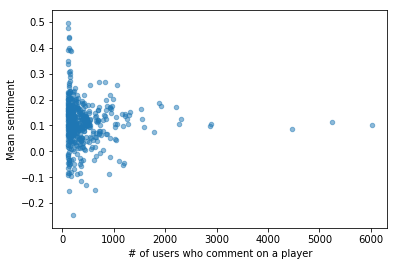

In [116]:
player_sentiment_df.query('user_count> 100').plot('user_count', 'compound_mean_mean', kind='scatter', alpha = 0.5)
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [138]:
player_sentiment_df.sort_values('user_count', ascending=False).head()

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
8122,tom brady,2017,0.100009,0.393209,6023
8121,tom brady,2016,0.112220,0.391103,5252
8120,tom brady,2015,0.088062,0.397033,4457
6683,peyton manning,2015,0.078099,0.409975,3001
63,aaron rodgers,2017,0.106130,0.405143,2884


#### Players with lowest sentiment

In [112]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').head()

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
6032,michael bennett,2017,-0.246940,0.435785,196
2159,danny trevathan,2017,-0.154172,0.460932,129
8543,vontaze burfict,2015,-0.148135,0.425746,635
8544,vontaze burfict,2016,-0.128823,0.445835,454
491,aqib talib,2017,-0.116155,0.413003,367


#### Players with highest sentiment

In [143]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
3517,j.j. watt,2017,0.237955,0.369052,921
2331,david johnson,2016,0.244761,0.422810,241
2658,devonta freeman,2016,0.355716,0.338264,321
2659,devonta freeman,2017,0.369017,0.339762,277
2657,devonta freeman,2015,0.389680,0.323972,408


In [146]:
# temporary until I re-run sentiment scoring
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "devonta freeman"')

#### Players with highest std of sentiment

In [147]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
3617,jake locker,2017,-0.021055,0.498718,925
3604,jake butt,2016,-0.055289,0.486843,364
3616,jake locker,2016,-0.004862,0.484268,730
624,bear pascoe,2017,0.110882,0.481373,209
5065,kevin boss,2017,0.004269,0.476982,437


#### Join player sentiment to performance and demographics
Include only players with at least 100 comments to avoid fitting noise

In [251]:
join_df = (player_sentiment_df#.query('user_count > 20')
                         .merge(covariates_df, left_on = ['fuzzy_name', 'year'],
                                                right_on = ['Player', 'year'])
                        )

### Explore demographics relationship with sentiment

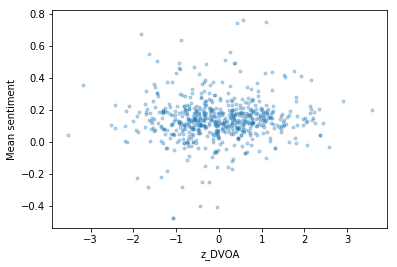

In [253]:
plt.plot(join_df['z_DVOA'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.3);
plt.xlabel('z_DVOA')
plt.ylabel('Mean sentiment');

In [254]:
join_df.groupby('race').mean()

,year,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,level_1,start_year,end_year,height,weight,salary,standard_salary,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
race,,,,,,,,,,,,,,,,,,,,,,
B,2016.000000,0.147722,0.420984,102.312207,92.802817,-0.606103,5.377934,-0.081285,-0.083909,-0.008029,3.854460,2012.171362,2017.680751,72.809859,215.542254,3.846497e+06,14.616503,4.913894e+06,69.795070,15.234272,0.320263,3.828638
L,2016.000000,0.119213,0.425482,172.000000,6.000000,-11.700000,1.000000,-0.813640,-0.770682,-1.253929,5.000000,2010.000000,2016.000000,72.000000,204.000000,4.400000e+06,15.297115,2.003144e+07,58.700000,17.100000,0.618300,6.000000
M,2016.500000,0.100318,0.420494,14.000000,1.000000,3.550000,3.000000,-0.341686,0.244330,-0.198692,2.500000,2014.000000,2018.000000,75.000000,235.000000,1.674250e+06,14.067249,6.047721e+06,67.500000,20.900000,0.669100,2.500000
S,2015.900000,0.072302,0.436515,241.900000,132.500000,-0.560000,8.400000,-0.293282,-0.073992,-0.273497,2.700000,2013.100000,2017.300000,73.300000,213.400000,2.752745e+06,14.412318,2.661782e+06,77.990000,12.550000,0.227165,2.800000
W,2015.951515,0.123257,0.429814,449.454545,258.224242,3.572121,11.830303,0.195704,0.185502,0.123233,5.709091,2010.230303,2017.612121,75.703030,232.993939,7.117442e+06,15.128777,5.033248e+06,69.804848,15.238182,0.353078,5.721212


#### Age / experience

Text(0,0.5,'Mean sentiment')

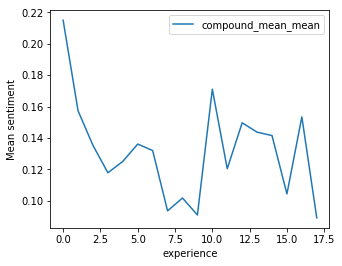

In [259]:
fig, ax1 = plt.subplots(1,1, figsize = [5, 4], sharey=True)
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax1);
ax1.set_ylabel('Mean sentiment')

#### Height

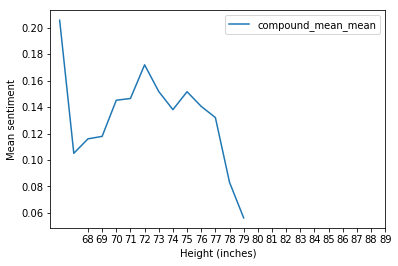

In [175]:
join_df.groupby('height').mean().reset_index().plot('height', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [260]:
join_df.groupby('position').mean().reset_index()

,position,year,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,level_1,start_year,end_year,height,weight,salary,standard_salary,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,qb,2015.989691,0.117325,0.424450,832.010309,437.443299,0.663918,21.154639,0.030433,0.039127,0.062883,6.237113,2009.762887,2017.731959,75.371134,224.278351,1.096479e+07,15.732799,5.130134e+06,69.684536,14.979381,0.344178,6.226804
1,rb,2016.016807,0.148632,0.421472,83.352941,58.991597,-1.149580,5.285714,-0.077998,-0.076357,-0.008293,3.596639,2012.512605,2017.655462,71.226891,220.722689,2.779804e+06,14.356935,5.205743e+06,69.663866,15.714286,0.343379,3.504202
2,te,2015.961240,0.135099,0.431612,41.635659,39.178295,0.145736,3.596899,0.024285,-0.006770,0.079207,4.720930,2011.271318,2017.589147,76.682171,255.550388,3.286496e+06,14.581980,4.629318e+06,69.894574,15.875194,0.318681,4.689922
3,wr,2015.984556,0.146002,0.420724,94.088803,111.845560,1.446332,4.590734,-0.013780,0.000019,-0.010825,3.779923,2012.169884,2017.656371,72.525097,201.104247,3.972911e+06,14.652317,4.896760e+06,70.109266,14.739768,0.322628,3.814672


#### Create modeling dataframe

In [261]:
join_df['youth'] = (join_df['experience'].mean() - join_df['experience']).clip(0)
join_df['oldness'] = (join_df['experience'] - join_df['experience'].mean()).clip(0)

In [262]:
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']
join_df['height_dummies'] = pd.cut(join_df['height'], [0, 72, 100], labels = ['short', 'tall'])
join_df['standard_salary'] = join_df['standard_salary'].fillna(join_df['standard_salary'].mean())

In [263]:
join_df.to_csv('modeling_data/nfl_model_data.tsv', sep='\t', index=False)

### Regression model
First, a regression model with team wins, age, oldness, PER, and ethnicity

In [268]:
fit_df = join_df.copy().query('user_count > 50').replace({'L':'B', 'S':'B'})

In [269]:
fit_df.columns

Index(['fuzzy_name', 'year', 'compound_mean_mean', 'compound_mean_std',
       'user_count', 'Player_FO', 'Tm', 'position', 'DYAR', 'DVOA', 'TD',
       'z_DYAR', 'z_DVOA', 'z_TD', 'player_join', 'Player', 'level_1',
       'start_year', 'end_year', 'url', 'height', 'weight', 'birth_date',
       'race', 'salary', 'standard_salary', 'total_population',
       'metro_percent_white', 'metro_percent_black', 'clinton_vote_lead',
       'experience', 'youth', 'oldness', 'white_black_diff', 'height_dummies'],
      dtype='object')

In [270]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + z_DVOA + height_dummies + position + standard_salary'\
                       ' + white_black_diff * C(race) + clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [271]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.120
Model:                            WLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.803
Date:                Sun, 21 Oct 2018   Prob (F-statistic):            0.00131
Time:                        22:10:17   Log-Likelihood:                 392.03
No. Observations:                 259   AIC:                            -758.1
Df Residuals:                     246   BIC:                            -711.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1906      0.070      2.736      0.007       0.053       0.328
height_dummies[T.tall]            0.0204      0.009      2.272      0.024       0.003       0.038
position[T.rb]                    0.0247      0.014      1.830      0.068      -0.002       0.051
position[T.te]                   -0.0137      0.015     -0.943      0.347      -0.042       0.015
position[T.wr]                   -0.0039      0.011     -0.370      0.711      -0.025       0.017
C(race)[T.W]                      0.0221      0.024      0.914      0.362      -0.026       0.070
youth                             0.0007      0.003      0.249      0.804      -0.005       0.007
oldness                          -0.0006      0.001     -0.599      0.550      -0.003       0.001
z_DVOA                            0.0122      0.003      3.866      0.000       0.006       0.018
standard_salary                  -0.0061      0.004     -1.486      0.138      -0.014       0.002
white_black_diff              -2.499e-05      0.000     -0.080      0.937      -0.001       0.001
white_black_diff:C(race)[T.W]    -0.0004      0.000     -0.929      0.354      -0.001       0.000
clinton_vote_lead                 0.0098      0.017      0.588      0.557      -0.023       0.043
==============================================================================
Omnibus:                        1.147   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                1.244
Skew:                          -0.149   Prob(JB):                        0.537
Kurtosis:                       2.836   Cond. No.                     1.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""